In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D , MaxPooling2D , BatchNormalization , GlobalAveragePooling2D
from tensorflow.keras.models import save_model,Model
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tensorflow_datasets as tfds

# Load dataset

In [3]:
dataset , info = tfds.load("deep_weeds", split = "train"  ,with_info = True)

In [4]:
info

tfds.core.DatasetInfo(
    name='deep_weeds',
    full_name='deep_weeds/3.0.0',
    description="""
    The DeepWeeds dataset consists of 17,509 images capturing eight different weed species native to Australia in situ with neighbouring flora.The selected weed species are local to pastoral grasslands across the state of Queensland.The images were collected from weed infestations at the following sites across Queensland: "Black River", "Charters Towers",  "Cluden", "Douglas", "Hervey Range", "Kelso", "McKinlay" and "Paluma".
    """,
    homepage='https://github.com/AlexOlsen/DeepWeeds',
    data_path='C:\\Users\\aeroa\\tensorflow_datasets\\deep_weeds\\3.0.0',
    file_format=tfrecord,
    download_size=469.32 MiB,
    dataset_size=469.99 MiB,
    features=FeaturesDict({
        'image': Image(shape=(256, 256, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=9),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
    

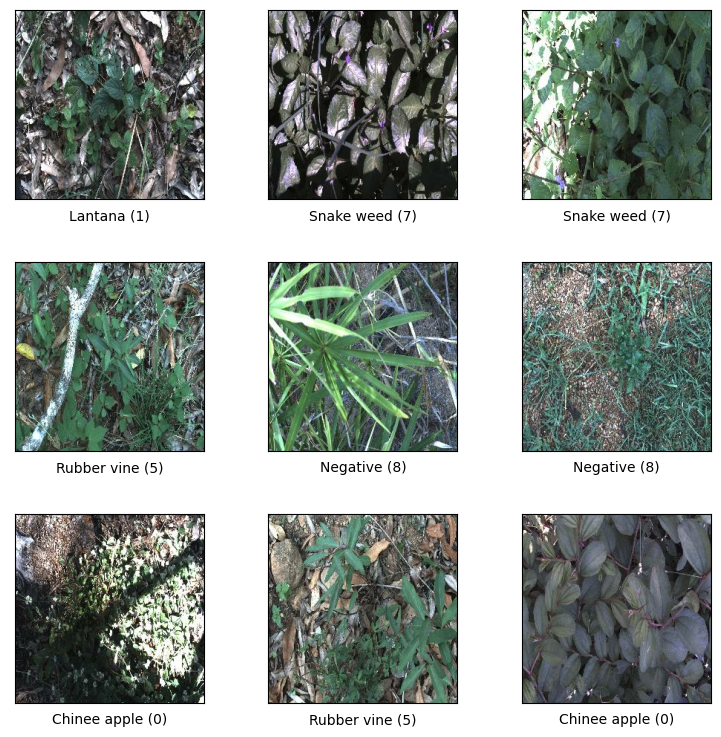

In [5]:
fig = tfds.show_examples(ds = dataset.take(9), ds_info=info)

In [6]:
batch_size = 256
dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

#  Build Model

In [7]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.conv1 = Conv2D(8, 3 , padding='same' ,  activation='relu') 
        self.max1 = MaxPooling2D(pool_size = 2)
        
        
        self.conv2 = Conv2D(16 , 3 , padding='same' , activation='relu')
        self.max2 = MaxPooling2D(pool_size = 2)
        
        self.conv3 = Conv2D(32 , 3 , padding='same' , activation = 'relu')
        self.max3 = MaxPooling2D(pool_size = 2)
        
        self.conv4 = Conv2D(64 , 3 , padding='same' , activation = 'relu')
        self.max4 = MaxPooling2D(pool_size = 2)
        
        self.flatten = Flatten()
        self.d = Dense(512 , activation = 'relu')
        self.d1 = Dense(64 , activation = 'relu')
        self.d2 = Dense(9  , activation = 'softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.max1(x)
        
        x = self.conv2(x)
        x = self.max2(x)
        
        x = self.conv3(x)
        x = self.max3(x)
        
        x = self.conv4(x)
        x = self.max4(x)
        
        x = self.flatten(x)
        x = self.d(x)
        x = self.d1(x)
        x = self.d2(x)
        return x

In [8]:
model = MyModel()
model.build(input_shape = (None,224,224,3))
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  224       
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           multiple                  1168      
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           multiple                  4640      
                                                                 
 max_pooling2d_2 (MaxPooling  multiple                 0  

In [9]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [10]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [11]:
@tf.function
def train_step(x_train, y_train  ,model):
    with tf.GradientTape() as tape:
        predictions = model(x_train, training=True)
        loss = loss_object(y_train, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(y_train, predictions)

# Train

In [12]:
EPOCHS = 5
for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()

    for data in dataset:
        images = data["image"]
        labels = data["label"]
        resized_images = tf.map_fn(lambda image: np.resize(image, (224,224 , 3)), images)
        train_step(tf.cast(resized_images , tf.float32) / 255.0 , labels , model)


    print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result()}, '
  )


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1, Loss: 1.6729375123977661, Accuracy: 0.5069392919540405, 
Epoch 2, Loss: 1.4755518436431885, Accuracy: 0.529213547706604, 
Epoch 3, Loss: 1.3999475240707397, Accuracy: 0.5390370488166809, 
Epoch 4, Loss: 1.3524558544158936, Accuracy: 0.544120192527771, 
Epoch 5, Loss: 1.3055191040039062, Accuracy: 0.5477754473686218, 


# Save model without transfer

In [13]:
save_model(model,"model")

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


# Build model with Transfer learning

In [14]:
class TransferModel(Model):
    def __init__(self):
        super(TransferModel, self).__init__()
        self.pre_model = tf.keras.applications.VGG19(weights='imagenet' , input_shape = (224,224,3) , include_top=False)
        self.pre_model.trainable = False
        self.apool = GlobalAveragePooling2D()
        self.flatten = Flatten()
        self.d = Dense(512 , activation = 'relu')
        self.d1 = Dense(9  , activation = 'softmax')

    def call(self, x):
        x = self.pre_model(x)
        x = self.apool(x)
        x = self.flatten(x)
        x = self.d(x)
        x = self.d1(x)
        return x

In [15]:
model_transfer = TransferModel()

# Train  ( for transfer learning )

In [18]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [19]:
@tf.function
def train_step(x_train, y_train):
    with tf.GradientTape() as tape:
        predictions = model_transfer(x_train, training=True)
        loss = loss_object(y_train, predictions)
    gradients = tape.gradient(loss, model_transfer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_transfer.trainable_variables))

    train_loss(loss)
    train_accuracy(y_train, predictions)

In [ ]:
EPOCHS = 5
for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()

    for data in dataset:
        images = data["image"]
        labels = data["label"]
        resized_images = tf.map_fn(lambda image: np.resize(image, (224,224 , 3)), images)
        train_step(tf.cast(resized_images , tf.float32) / 255.0 , labels)
        
    print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result()}, '
  )

Epoch 1, Loss: 1.6629921197891235, Accuracy: 0.5139642357826233, 
Epoch 2, Loss: 1.4949315786361694, Accuracy: 0.520989179611206, 


# Save Transfer learning model

In [ ]:
save_model(model_transfer , 'model_with_transfer')